# Regressor strategies used to predict PTV margins on single isocenter multiple brain metastases

Created by M.Sc. José Alejandro Rojas López

Contact: alejandro.rojas.lopez@mi.unc.edu.ar

Credits: To Instituto Zunino for providing the clinical information and the resources.

The use of these code and the dataset has open and closed validation. The clinical use is completely responsability of the final user. The authors recommend to validate the dose distributions and the dosimetric indices and reviewing the plan with the clinical staff of each institution before the final use of it.

More information is described in:
1. https://pubmed.ncbi.nlm.nih.gov/37311445/
2. https://pubmed.ncbi.nlm.nih.gov/34062337/
3. https://pypi.org/project/dicomhandler/

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

## Import the dataset

The dataset is called train.csv and is fed by 360 brain metastases of 55 plans for a single institution.

The dataset is divided in a training set (75% of the data: 316 mets) and a closed-validation set (25% of the data: 44 mets)

In [2]:
df = pd.read_csv("train.csv")
dataset = df.values
X = dataset[:, 0:6]
y = dataset[:, 6]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

## Multilayer perceptron (MLP)

We create a multilayer perceptron regressor of 70 layers, with activation function ReLU, the ADAM solver, learning rate 0.1

Accuracy training : 0.454
Accuracy testing : 0.364
Training set loss: 0.080630
MLP validation by mean absolute error (MAE) : 0.102


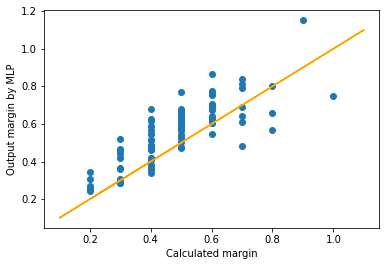

In [3]:
mlp = MLPRegressor(
    hidden_layer_sizes=70,
    activation="relu",
    random_state=100,
    solver="adam",
    alpha=0.9,
    epsilon=0.00000001,
    max_iter=6000,
    max_fun=500,
    learning_rate_init=0.1,
    verbose=False,
).fit(X_train, y_train)
plt.scatter(y_test, mlp.fit(X_train, y_train).predict(X_test))
plt.xlabel("Calculated margin")
plt.ylabel("Output margin by MLP")
_ = plt.plot(y, y, color="orange")
print("Accuracy training : {:.3f}".format(mlp.score(X_train, y_train)))
print("Accuracy testing : {:.3f}".format(mlp.score(X_test, y_test)))
print("Training set loss: %f" % mlp.loss_)
predicted_values_mlp = mlp.predict(X_test)
# Predicting the mean absolute error (MAE)
MAE_mlp = mean_absolute_error(y_test, predicted_values_mlp)
print("MLP validation by mean absolute error (MAE) : {:.3f}".format(MAE_mlp))

## Random forest regressor (RFR)

We create a random forest regressor.

Accuracy training : 0.938
Accuracy testing : 0.494
Random forest validation by mean absolute error (MAE) : 0.082


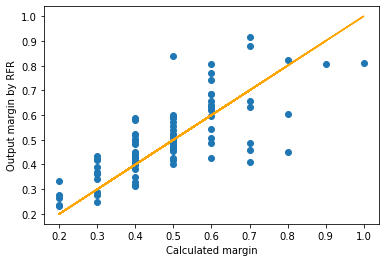

In [4]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
plt.scatter(y_test, rfr.fit(X_train, y_train).predict(X_test))
plt.xlabel("Calculated margin")
plt.ylabel("Output margin by RFR")
_ = plt.plot(y_test, y_test, color="orange")
print("Accuracy training : {:.3f}".format(rfr.score(X_train, y_train)))
print("Accuracy testing : {:.3f}".format(rfr.score(X_test, y_test)))
# Get the mean absolute error on the validation data
predicted_values_rfr = rfr.predict(X_test)
MAE_rfr = mean_absolute_error(y_test, predicted_values_rfr)
print("Random forest validation by mean absolute error (MAE) : {:.3f}".format(MAE_rfr))

## XGBoost (xgb)

We create an extreme gradient boost regressor of learning rate 0.1.

Accuracy training : 0.992
Accuracy testing : 0.409
XGBoost validation by mean absolute error (MAE) : 0.087


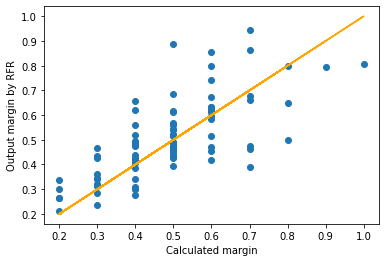

In [5]:
xgb = XGBRegressor(
    random_state=1,
    booster="gbtree",
    validate_parameters=False,
    learning_rate=0.1,
    sampling_method="uniform",
).fit(X_train, y_train, verbose=True)
plt.scatter(y_test, xgb.fit(X_train, y_train).predict(X_test))
plt.xlabel("Calculated margin")
plt.ylabel("Output margin by RFR")
_ = plt.plot(y_test, y_test, color="orange")
print("Accuracy training : {:.3f}".format(xgb.score(X_train, y_train)))
print("Accuracy testing : {:.3f}".format(xgb.score(X_test, y_test)))
# Get the mean absolute error on the validation data
predicted_values_xgb = xgb.predict(X_test)
MAE_xgb = mean_absolute_error(y_test, predicted_values_xgb)
print("XGBoost validation by mean absolute error (MAE) : {:.3f}".format(MAE_xgb))

## Introduce the inputs to determine the margin of a brain metastasis

The inputs have to be introduced as a 1-D vector of six values.
1. The total number of brain metastases for the plan.
2. The brain lobe where the metastasis is located:
    1. Left parietal
    2. Right parietal
    3. Left temporal
    4. Right temporal
    5. Left occipital
    6. Right occipital
    7. Left frontal
    8. Right frontal
    9. Cerebelum
3. The GTV volume (in cc)
4. The GTV size (in cm)
5. The distance to isocenter (in mm)
6. The dose cluster formation. If you are not sure of this item, please put 0.
    1. 0 if not (or the metastasis is not closed to other ones)
    2. 1 if yes (or the metastasis is closed to other ones)
    
For example, the next example considers a plan of 19 metastases, one of them located on the right occipital brain lobe, with a GTV volume of 1.008 cc, a GTV size of 1.79 cmm at 45 mm of the isocenter. No dose cluster formation information is given. The output is a margin of 0.6 mm using the XGBoost strategy.

In [6]:
vector = np.array([[19, 6, 1.008, 1.79, 45, 0]])
print(f"MLP: {mlp.predict(vector)}")
print(f"RFR: {rfr.predict(vector)}")
print(f"XGB: {xgb.predict(vector)}")

MLP: [0.50488815]
RFR: [0.525]
XGB: [0.5739041]
